In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/lavish619/VHR-10_dataset_coco
%cd VHR-10_dataset_coco

Cloning into 'VHR-10_dataset_coco'...
remote: Enumerating objects: 861, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 861 (delta 11), reused 29 (delta 7), pack-reused 822
Receiving objects: 100% (861/861), 362.97 MiB | 25.96 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/VHR-10_dataset_coco


In [3]:
import matplotlib.pyplot as plt
import random

import torch

from torchvision import transforms
from dataset import prepare_dataset

# use same transform for train/val for this example
size = (450,675)
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size),
    transforms.Normalize([0.3394, 0.3598, 0.3226], [0.2037, 0.1899, 0.1922]),
])

target_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size),
])

dataset_dir = './NWPU VHR-10_dataset_coco'
train_annotations = f'{dataset_dir}/instances_train2017.json'
val_annotations = f'{dataset_dir}/instances_val2017.json'
images_path = f'{dataset_dir}/positive image set'

batch_size = 4
dataloaders, image_sets = prepare_dataset(images_path, train_annotations, val_annotations, 
                              batch_size = batch_size, transform = trans, target_transform = target_trans)

train_set, val_set = image_sets['train'], image_sets['val']


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
print(f"Train_Image Count: {len(train_set.image_ids)},\
        Val Image Count: {len(val_set.image_ids)}")

print(f"Train Class Count: {train_set.num_classes}, Val Class Count: {val_set.num_classes}" )
for i, info in enumerate(train_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Train_Image Count: 520,        Val Image Count: 130
Train Class Count: 10, Val Class Count: 10
  0. airplane                                          
  1. ship                                              
  2. storage_tank                                      
  3. baseball_diamond                                  
  4. tennis_court                                      
  5. basketball_court                                  
  6. ground_track_field                                
  7. harbor                                            
  8. bridge                                            
  9. vehicle                                           


In [5]:
import numpy as np
import torch.nn.functional as F
import torch

def denormalize(img,mean= [0.3394, 0.3598, 0.3226] , std = [0.2037, 0.1899, 0.1922]):
    img = img * np.array(std) + np.array(mean)
    return img

def to_rgb(mask, colors):
    C,H,W = mask.shape
    bg_channel = torch.zeros((1,H,W))
    mask = mask.cpu()
    mask  = torch.cat((bg_channel, mask), dim=0)
    mask = F.softmax(mask, dim=0).argmax(dim=0)
    mask = mask.cpu().detach().numpy()
    
    image = np.zeros((H,W,3))
    image = colors[mask]
    
    return image

In [6]:
np.random.seed(42)
colors = np.random.uniform(0,255, size=(train_set.num_classes+1,3))
count=0

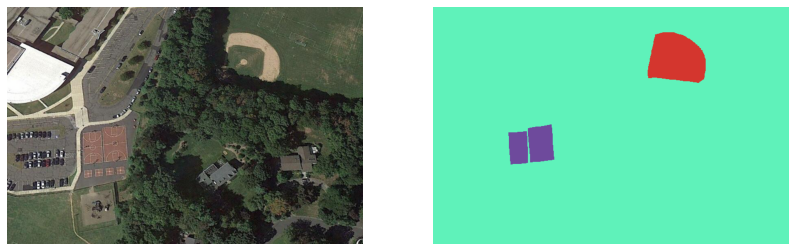

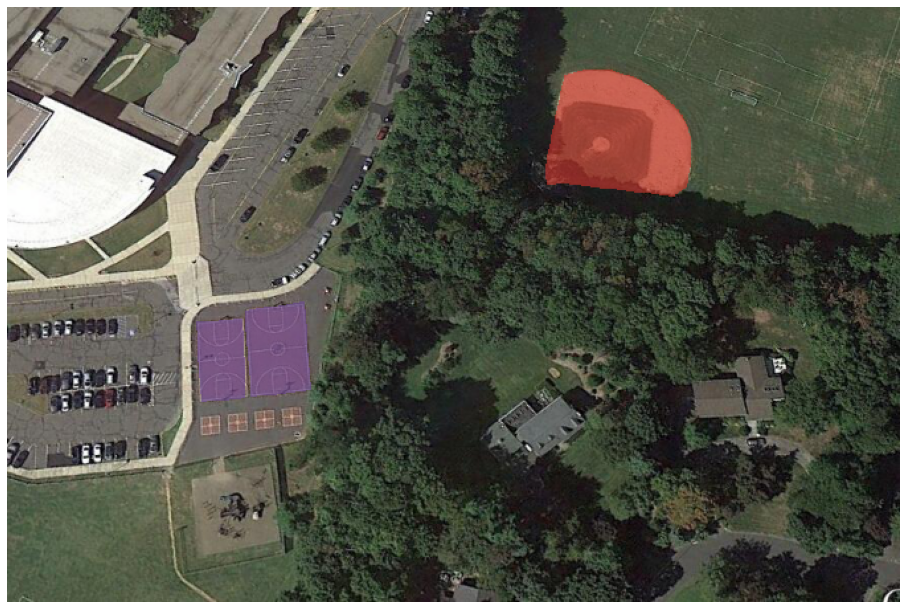

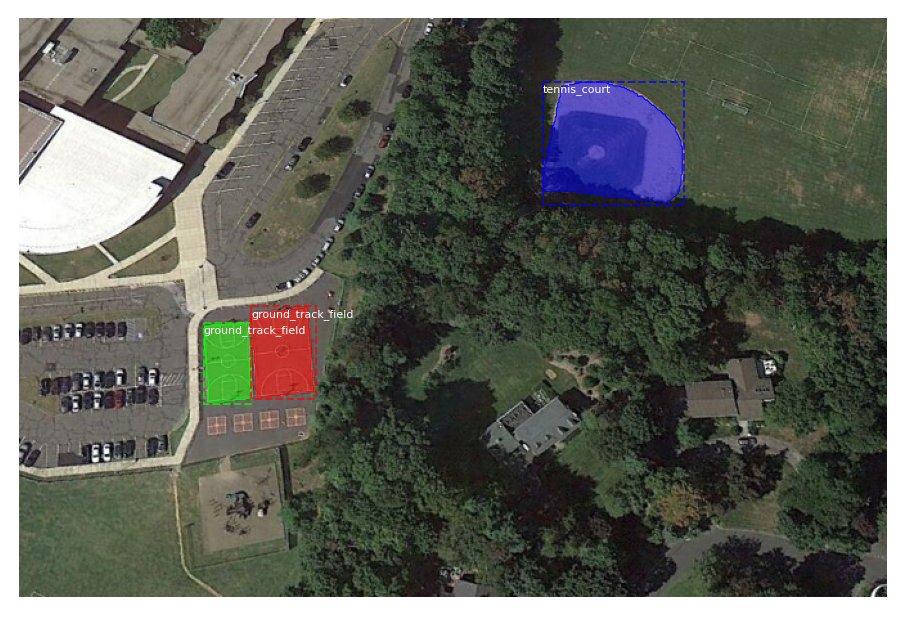

In [9]:
from lib import visualize
from lib import utils

imgs, masks , ids = next(iter(dataloaders['train']))
x = 1
image, mask, id = imgs[x], masks[x], ids[x]

img = denormalize(image.permute(1,2,0).cpu().detach().numpy())*255.0

visualize.display_images([img, to_rgb(mask, colors) ], cols=2)
visualize.display_sematics(img, mask, colors, count)
count += 1

#Visualize Instance Masks
mask_1, class_ids = train_set.load_mask(id)
mask_1 = utils.resize(mask_1, size)
bbox = utils.extract_bboxes(mask_1)

visualize.display_instances(img, bbox, mask_1, class_ids, train_set.class_names)

In [ ]:
from torchsummary import summary
from models.deeplabv1 import DeepLabLargeFOV

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = DeepLabLargeFOV(train_set.num_classes, rates=[1,2,4,12]).to(device)
summary(model, (3,600,900))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 600, 900]           1,792
              ReLU-2         [-1, 64, 600, 900]               0
            Conv2d-3         [-1, 64, 600, 900]          36,928
              ReLU-4         [-1, 64, 600, 900]               0
         MaxPool2d-5         [-1, 64, 300, 450]               0
            Conv2d-6        [-1, 128, 300, 450]          73,856
              ReLU-7        [-1, 128, 300, 450]               0
            Conv2d-8        [-1, 128, 300, 450]         147,584
              ReLU-9        [-1, 128, 300, 450]               0
        MaxPool2d-10        [-1, 128, 150, 225]               0
           Conv2d-11        [-1, 256, 150, 225]         295,168
             ReLU-12        [-1, 256, 150, 225]               0
           Conv2d-13        [-1, 256, 150, 225]         590,080
             ReLU-14        [-1,

In [ ]:
from torch.optim import lr_scheduler
from train import train_model
import torch.optim as optim
import os

path = '/content/drive/MyDrive/Deeplab_models/'

# if os.path.exists(path+ 'v2_r24812_2.pt'):
#     model.load_state_dict(torch.load(path+ 'v2_r24812_2.pt', map_location=device))
#     print('model weights loaded')

# # Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=5e-5)

num_epochs=25

lambda_lr = lr_scheduler.LambdaLR(optimizer_ft, lr_lambda=lambda epoch : (1-epoch/num_epochs)**(0.9))

model, losses, class_miou, total_miou = train_model(model, dataloaders, optimizer_ft, lambda_lr, num_epochs=num_epochs)
# torch.save(model.state_dict(), path+"v1_12412.pt")

Epoch 0/24
----------
LR 5e-05



train: bce: 0.116848, dice: 0.285962, loss: 0.201405, mIoU: 0.034966
train: mIOU classes, cls_1: 0.000063, cls_2: 0.000017, cls_3: 0.000185, cls_4: 0.000500, cls_5: 0.000238, cls_6: 0.000604, cls_7: 0.199476, cls_8: 0.000002, cls_9: 0.000288, cls_10: 0.000405



val: bce: 0.083232, dice: 0.139179, loss: 0.111206, mIoU: 0.000000
val: mIOU classes, cls_1: 0.000000, cls_2: 0.000000, cls_3: 0.000000, cls_4: 0.000000, cls_5: 0.000000, cls_6: 0.000000, cls_7: 0.000000, cls_8: 0.000000, cls_9: 0.000000, cls_10: 0.000000
saving best model
5m 50s
Epoch 1/24
----------
LR 4.819634606292755e-05


KeyboardInterrupt: ignored

### Plot the loss and mIOU curves

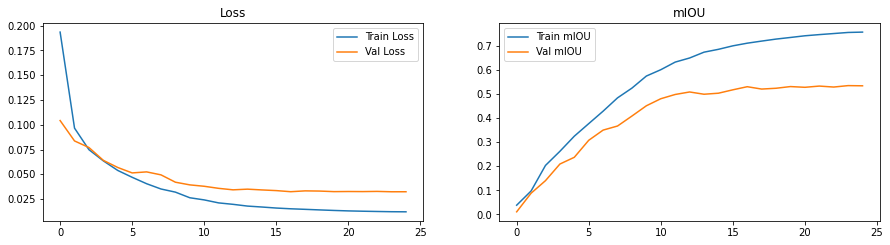

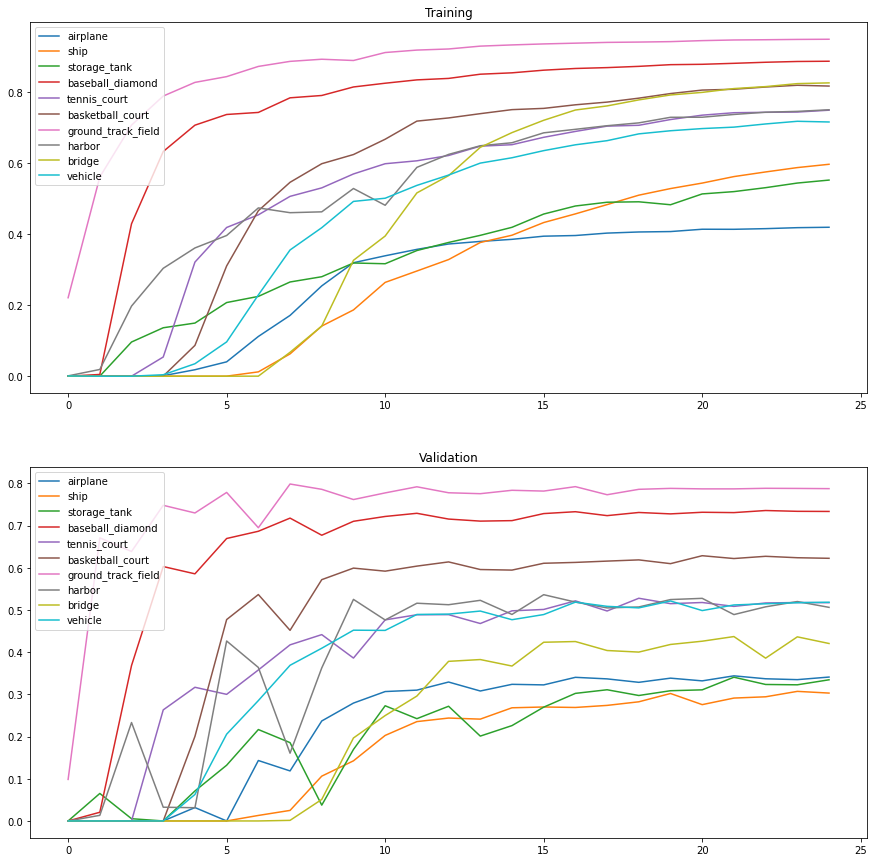

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
epochs = len(losses['train'])
plt.plot(range(epochs), losses['train'], label="Train Loss")
plt.plot( range(epochs), losses['val'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(2,2,2)
plt.plot(range(epochs), total_miou['train'], label="Train mIOU")
plt.plot(range(epochs), total_miou['val'], label="Val mIOU")
plt.legend()
plt.title("mIOU")

plt.savefig("Loss_mIOU")

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
for cls in class_miou['train'].keys():
    plt.plot( range(epochs), class_miou['train'][cls], label=f'{train_set.class_info[cls-1]["name"]}')
plt.legend(loc=2)
plt.title("Training")

plt.subplot(2,1,2)
for cls in class_miou['val'].keys():
    plt.plot( range(epochs), class_miou['val'][cls], label=f'{train_set.class_info[cls-1]["name"]}')
plt.legend(loc=2)
plt.title("Validation")
plt.savefig("class_iou")



### Visualize the predictions

torch.Size([10, 450, 675])


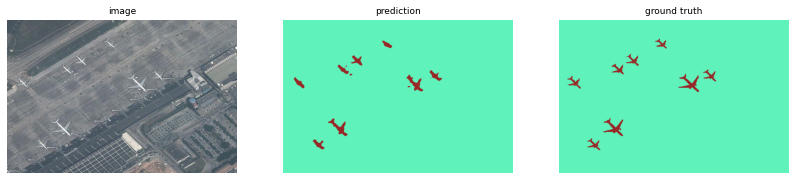

torch.Size([10, 450, 675])


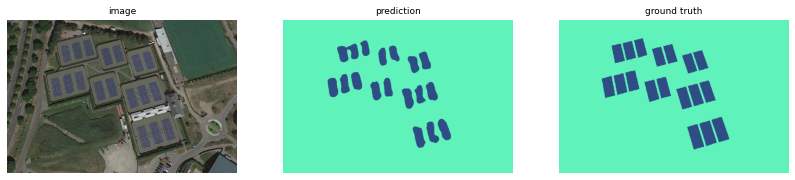

torch.Size([10, 450, 675])


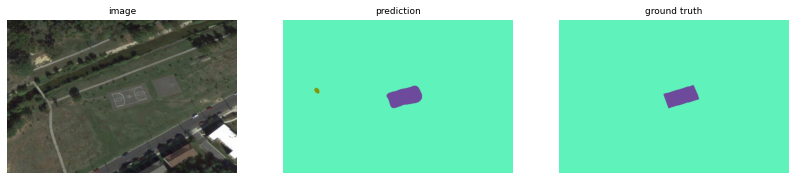

torch.Size([10, 450, 675])


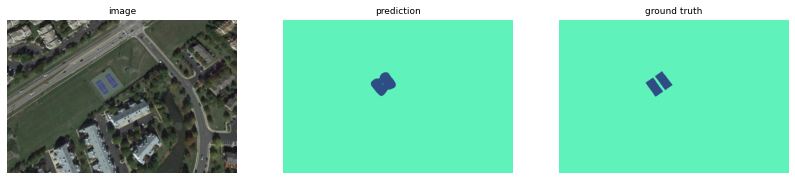

In [ ]:
imgs, masks,_ = next(iter(dataloaders['val']))
for x in range(batch_size): 
    image, mask  = imgs[x], masks[x]
    # print(mask.shape)
    C,H,W = image.shape
    rgb_mask = to_rgb(mask,colors)
    img_ = image.permute(1,2,0).cpu().detach().numpy()
    img_ = denormalize(img_)
    
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).squeeze(0)
    
    # print(pred.shape)
    rgb_pred = to_rgb(pred, colors)

    visualize.display_images([img_*255, rgb_pred, rgb_mask],
                             titles=["image", 'prediction','ground truth'],cols=3)
   

In [ ]:
def calc_avg_hw(dataset):
    heights = [dataset.image_info[i]['height'] for i in range(len(dataset.image_ids)) ]
    widths = [dataset.image_info[i]['width'] for i in range(len(dataset.image_ids))]
    return  [sum(heights)/len(heights),  sum(widths)/len(widths)]

# print(calc_avg_hw(train_set))

def calc(train_set):
    imgs = torch.stack([img for img,_,_ in train_set], dim = -1)
    print(imgs.shape)
    imgs = imgs.view(imgs.shape[0],-1)
    print(imgs.shape)
    mean = imgs.mean(dim = -1)
    std = imgs.std(dim=-1)
    print(mean, std)

# calc(train_set)

[607.8538461538461, 936.9346153846154]
[618.1923076923077, 950.3538461538461]
torch.Size([3, 300, 450, 520])
torch.Size([3, 70200000])
tensor([0.3355, 0.3553, 0.3175]) tensor([0.2024, 0.1895, 0.1904])
